# Predicting Sports Winners with Decision Trees

NBA(National Basketball Association) 경기의 승패는 마지막 순간에 결정되어 승자 예측이 어려운 경우가 많다.

2013-2014 년도 NBA 데이터셋과 decision trees 모델을 사용하여 게임의 승자를 예측해보자.

NBA dataset 
```
https://www.basketball-reference.com/leagues/NBA_2014_games-november.html
```

## Using pandas to load the dataset

In [5]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from collections import defaultdict

In [6]:
np.random.seed(1004)

In [7]:
dataset = pd.read_csv('./dataset/NBA_14oct-jun.csv')

In [8]:
dataset.rename(columns={'PTS': 'visitorPTS', 'PTS.1': 'homePTS', 'Unnamed: 6':'Score type', 'Unnamed: 7':'OT?','Attend.':'Attend', 'Visitor/Neutral':'Visitor team', 'Home/Neutral':'Home team'}, inplace=True)

In [9]:
# 일부 Column만 사용
dataset = dataset[['Visitor team','visitorPTS','Home team','homePTS']]
dataset.head(3)

,Visitor team,visitorPTS,Home team,homePTS
0,Orlando Magic,84,New Orleans Pelicans,101
1,Dallas Mavericks,100,San Antonio Spurs,101
2,Houston Rockets,108,Los Angeles Lakers,90


## Extracting new features

데이터로부터 다음과 같은 feature들을 추출.
* HomeLastWin : 홈팀이 지난경기에서 이기면 1, 지면 0  
* VisitorLastWin : 원정팀이 지난경기에서 이기면 1, 지면 0  
* HomeTeamRanksHigher : 홈팀 랭킹이 원정팀 랭킹보다 높으면 1, 아니면 0  
* HomeTeamWonLast : 지난 홈팀 vs 원정팀 경기에서 홈팀이 이겼으면 1, 아니면 0

In [10]:
dataset["HomeWin"] = dataset["visitorPTS"] < dataset["homePTS"]

In [11]:
y_true = dataset["HomeWin"].values
print(y_true.shape)

(1311,)


In [12]:
y_true[:10]

array([ True,  True, False,  True,  True,  True,  True,  True, False,
        True])

In [11]:
won_last = defaultdict(int)

In [13]:
dataset2 = pd.DataFrame()
for index, row in dataset.iterrows():  
    home_team = row["Home team"]  
    visitor_team = row["Visitor team"] 
    row["HomeLastWin"] = won_last[home_team] 
    row["VisitorLastWin"] = won_last[visitor_team]
    won_last[home_team] = row["HomeWin"]
    won_last[visitor_team] = not row["HomeWin"]
    dataset.iloc[index] = row
    dataset2 = dataset2.append(row)

In [14]:
dataset2.tail(3)

,Home team,HomeLastWin,HomeWin,Visitor team,VisitorLastWin,homePTS,visitorPTS
1308,Cleveland Cavaliers,1.0,0.0,Golden State Warriors,0.0,82.0,103.0
1309,Golden State Warriors,1.0,1.0,Cleveland Cavaliers,0.0,104.0,91.0
1310,Cleveland Cavaliers,0.0,0.0,Golden State Warriors,1.0,97.0,105.0


We will create a feature that tells us if the home team is generally better than the visitors. To do this, we will load the standings (also called a ladder in some sports) from the NBA in the previous season. A team will be considered better if it ranked higher in 2013 than the other team.

In [15]:
data_folder = './'

In [16]:
standings_filename = os.path.join(data_folder, "NBA_14standings.csv")
standings = pd.read_csv(standings_filename)

In [17]:
standings.head(2)

,Rk,Team,Overall,Home,Road,E,W,A,C,SE,...,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
0,1,Golden State Warriors,67-15,39-2,28-13,25-5,42-10,9-1,7-3,9-1,...,25-6,5-3,45-9,1-0,13-2,11-3,12-3,8-3,16-2,6-2
1,2,Atlanta Hawks,60-22,35-6,25-16,38-14,22-8,12-6,14-4,12-4,...,17-11,6-4,30-10,0-1,9-5,14-2,17-0,7-4,9-7,4-3


As an important adjustment to the data, a team was renamed between the 2014 and 2015 seasons (but it was still the same team). We will need to adjust.

* HomeTeamRanksHigher : 홈팀 랭킹이 원정팀 랭킹보다 높으면 1, 아니면 0

In [18]:
dataset2["HomeTeamRanksHigher"] = 0

dataset3 = pd.DataFrame()
for index, row in dataset2.iterrows():
    home_team = row["Home team"]
    visitor_team = row["Visitor team"]
    home_rank = standings[standings["Team"] == home_team]["Rk"].values[0]
    visitor_rank = standings[standings["Team"] == visitor_team]["Rk"].values[0]
    row["HomeTeamRanksHigher"] = int(home_rank > visitor_rank)
    dataset2.iloc[index] = row
    dataset3 = dataset3.append(row)

In [19]:
dataset3.head(2)

,Home team,HomeLastWin,HomeTeamRanksHigher,HomeWin,Visitor team,VisitorLastWin,homePTS,visitorPTS
0,New Orleans Pelicans,0.0,0.0,1.0,Orlando Magic,0.0,101.0,84.0
1,San Antonio Spurs,0.0,0.0,1.0,Dallas Mavericks,0.0,101.0,100.0


In [20]:
last_match_winner = defaultdict(int)
dataset3["HomeTeamWonLast"] = 0

In [21]:
dataset4 = pd.DataFrame()
for index, row in dataset3.iterrows():
    home_team = row["Home team"]
    visitor_team = row["Visitor team"]
    teams = tuple(sorted([home_team, visitor_team]))
    row["HomeTeamWonLast"] = 1 if last_match_winner[teams] == row["Home team"] else 0
    winner = row["Home team"] if row["HomeWin"] else row ["Visitor team"]
    last_match_winner[teams] = winner
    dataset4 = dataset4.append(row)

HomeTeamWonLast : 지난 홈팀 vs 원정팀 경기에서 홈팀이 이겼으면 1, 아니면 0

In [22]:
dataset4 = dataset4[['Visitor team', 'visitorPTS', 'Home team', 'homePTS','HomeWin','HomeLastWin','VisitorLastWin', 'HomeTeamRanksHigher','HomeTeamWonLast']]

In [23]:
dataset4.head(2)

,Visitor team,visitorPTS,Home team,homePTS,HomeWin,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,HomeTeamWonLast
0,Orlando Magic,84.0,New Orleans Pelicans,101.0,1.0,0.0,0.0,0.0,0.0
1,Dallas Mavericks,100.0,San Antonio Spurs,101.0,1.0,0.0,0.0,0.0,0.0


In [24]:
dataset4.to_csv('./NBA_14_all.csv',index = False)

We will also try putting the raw teams into the algorithm to check whether the algorithm can learn a model that checks how different teams play against each other

In [25]:
from sklearn.preprocessing import LabelEncoder
encoding = LabelEncoder()

In [26]:
encoding.fit(dataset4["Home team"].values)

LabelEncoder()

In [27]:
home_teams = encoding.transform(dataset4["Home team"].values)
visitor_teams = encoding.transform(dataset4["Visitor team"].values)
X_teams = np.vstack([home_teams, visitor_teams]).T

In [28]:
print(home_teams[:5])  
print(X_teams.shape)

[18 26 13  3 11]
(1311, 2)


In [29]:
X_teams[0]

array([18, 21])

In [30]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()

In [31]:
X_teams_expanded = onehot.fit_transform(X_teams).todense()

In [32]:
X_teams_expanded[0]  

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [60]:
X_teams_expanded[0].shape

(1, 60)

In [33]:
X_teams_expanded.shape

(1311, 60)

In [34]:
dataset4 = pd.concat([dataset4, pd.DataFrame(X_teams_expanded)], axis=1)

In [35]:
dataset4.shape

(1311, 69)

In [36]:
dataset5 = dataset4.iloc[:,5:]

#### feature explain
* HomeLastWin : Did the home team win the last game?
* VisitorLastWin : Did the visitor team win the last game?
* HomeTeamRanksHigher : Does the home team rank higher than the visitor team?
* HomeTeamWonLast : Did the home team win last home vs visitor game?
* 0-60 : one-hot encoding team number --> hometeam(0-29), visitor team(30-59)

In [37]:
dataset5.tail(3)

,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,HomeTeamWonLast,0,1,2,3,4,5,...,50,51,52,53,54,55,56,57,58,59
1308,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1309,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1310,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset5, y_true, test_size=0.3, random_state=0)

In [43]:
X_train.shape, X_test.shape

((917, 64), (394, 64))

### Neual Network

In [13]:
from tensorflow.keras import models, layers

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [45]:
model = models.Sequential()

W0518 11:28:23.904905 139819460454208 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [46]:
# adding the layers
model.add(layers.Dense(8, activation='relu', input_shape=[X_train.shape[1]]))
model.add(layers.Dense(16, activation='relu'))
# output layer
model.add(layers.Dense(1))

W0518 11:28:23.925249 139819460454208 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0518 11:28:23.927968 139819460454208 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

W0518 11:28:24.036870 139819460454208 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0518 11:28:24.055033 139819460454208 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0518 11:28:24.057897 139819460454208 deprecation.py:323] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [49]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100)

W0518 11:28:24.159259 139819460454208 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 733 samples, validate on 184 samples
Epoch 1/100
733/733 [==============================] - 1s 1ms/step - loss: 1.7184 - acc: 0.4284 - val_loss: 1.1228 - val_acc: 0.4239
Epoch 2/100
733/733 [==============================] - 0s 105us/step - loss: 1.0124 - acc: 0.4366 - val_loss: 0.9358 - val_acc: 0.4293
Epoch 3/100
733/733 [==============================] - 0s 103us/step - loss: 0.8497 - acc: 0.4502 - val_loss: 0.8455 - val_acc: 0.4348
Epoch 4/100
733/733 [==============================] - 0s 107us/step - loss: 0.7850 - acc: 0.4952 - val_loss: 0.7994 - val_acc: 0.4837
Epoch 5/100
733/733 [==============================] - 0s 102us/step - loss: 0.7625 - acc: 0.5389 - val_loss: 0.7740 - val_acc: 0.4891
Epoch 6/100
733/733 [==============================] - 0s 102us/step - loss: 0.7367 - acc: 0.5621 - val_loss: 0.7582 - val_acc: 0.5163
Epoch 7/100
733/733 [==============================] - 0s 98us/step - loss: 0.7158 - acc: 0.5866 - val_loss: 0.7475 - val_acc: 0.5435
Epoch 8/100


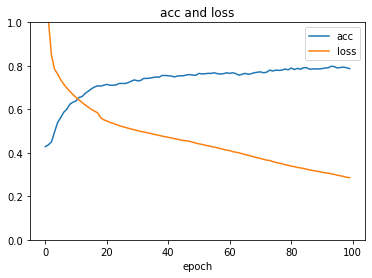

In [50]:
import matplotlib.pyplot as plt

training_error = history.history['acc'] # training error
val_error = history.history['loss'] # validation error

plt.plot(training_error)
plt.plot(val_error)
plt.title('acc and loss')
plt.legend(['acc', 'loss'], loc='upper right')
plt.ylim(0, 1)
plt.xlabel('epoch')

plt.show()

In [51]:
score = model.evaluate(X_train, y_train)
print('train_acc: {}'.format(score[1]))

917/917 [==============================] - 0s 26us/step
train_acc: 0.7437295535398544


In [52]:
score = model.evaluate(X_test, y_test)
print('test_acc: {}'.format(score[1]))

394/394 [==============================] - 0s 28us/step
test_acc: 0.586294416281475


### Conventional approach

https://towardsdatascience.com/building-my-first-machine-learning-model-nba-prediction-algorithm-dee5c5bc4cc1

In [53]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.7030456852791879

In [54]:
# LinearSVC classification 
from sklearn.svm import LinearSVC
lclf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
lclf.fit(X_train, y_train)
lclf.score(X_test,y_test)

0.6979695431472082

In [55]:
# KNN model attempt 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.6675126903553299

In [56]:
# SVC prediction model attempt 
from sklearn.svm import SVC
from sklearn import svm
clf = SVC(gamma='scale',probability=True)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.7055837563451777

In [57]:
#BaggingSVC Ensemble classification 
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
advclf = BaggingClassifier(base_estimator=SVC(gamma='scale'), n_estimators=10, random_state=0)
advclf.fit(X_train, y_train)
advclf.score(X_test,y_test)

0.7030456852791879

In [58]:
# Random Forest Classification model
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=8, random_state=0, n_estimators=300)
rdf.fit(X_train, y_train)
rdf.score(X_test,y_test)

0.7182741116751269

### References  
https://hub.packtpub.com/predicting-sports-winners-decision-trees-and-pandas/, Ch.3